### Модель Seq2Seq

Будем рассматривать модель sequence-to-sequence на примере перевода дат из одного формата в другой.

Обучим модель Encoder-Decoder на основе RNN.

Настройте аппаратный ускоритель GPU (Среда выполнения -> Сменить среду выполнения -> GPU)

Установим необходимые библиотеки.

In [1]:
# from __future__ import unicode_literals, print_function, division
from io import open #
# import unicodedata
# import string
# import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

# from beholder import print_methods

%matplotlib inline

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### 1. Get a datset from 1/1/1 to 31/12/9999

In [3]:
import datetime
from random import randrange
from datetime import timedelta


def get_random_date(
    start: datetime.datetime, end: datetime.datetime
) -> datetime.datetime:
    """Generate a random datetime between `start` and `end`
    Args:
        start: first date
        end: second date
    Returns:
        random_date: random date between `start` and `end`
    """
    delta = end - start
    int_delta = (
        delta.days * 24 * 60 * 60
    ) + delta.seconds  # total number of seconds between dates
    random_second = randrange(
        int_delta
    )  # random number of seconds between 0 and int_delta
    return (start + timedelta(seconds=random_second)).replace(
        hour=0, minute=0, second=0
    )


FORMATS = [
    "%d %b %Y",
    "%d %B %Y",
    "%B %dth, %Y",
    "%b %d, %Y",
    "%d.%m.%Y",
    "%b.%d.%Y",
    "%b%d%Y",
    "%d/%m/%Y",
    "%dth %m %Y",
    "%d-%b-%Y",
    "%dth of %B, %Y",
]

# TARGET_FORMAT = '%d-%m-%Y'
# TARGET_FORMAT = '%Y-%m-%d'

# to make things more complicated let's define target format with
# permutations of elements in date format (e.g year position)
# TARGET_FORMAT = '%Y %B %dth'
TARGET_FORMAT = "%Y, the %dth of %B"


def get_dataset(
    fst_dt: datetime.datetime,
    snd_dt: datetime.datetime,
    input_fmt_dt,
    dataset_size=100000,
) -> list[tuple]:
    """Generate a dataset of random date strings
    between `fst_dt` and `snd_dt` in format `fmt_dt`
    Args:
        fst_dt: first date
        snd_dt: second date
        fmt_dt: format of the date
    Returns:
        dataset: list of tuples (random_date, target_date)
    """
    fst_d = datetime.datetime.strptime(fst_dt, input_fmt_dt)
    snd_d = datetime.datetime.strptime(snd_dt, input_fmt_dt)
    dataset = []
    for i in range(dataset_size):
        date_format = random.choice(FORMATS)
        rand_dt = get_random_date(start=fst_d, end=snd_d)
        t = (
            datetime.datetime.strftime(rand_dt, date_format),
            datetime.datetime.strftime(rand_dt, TARGET_FORMAT),
        )
        dataset.append(t)
    return dataset


dataset = get_dataset(fst_dt="1/1/0001", snd_dt="1/1/9999", input_fmt_dt="%m/%d/%Y")
dataset[:20], len(dataset)

([('24 November 2495', '2495, the 24th of November'),
  ('Dec 03, 9171', '9171, the 03th of December'),
  ('13/10/4840', '4840, the 13th of October'),
  ('23th of May, 3054', '3054, the 23th of May'),
  ('29.04.2039', '2039, the 29th of April'),
  ('06/04/6964', '6964, the 06th of April'),
  ('May277689', '7689, the 27th of May'),
  ('23-Feb-3125', '3125, the 23th of February'),
  ('October 16th, 7919', '7919, the 16th of October'),
  ('November 21th, 2449', '2449, the 21th of November'),
  ('10th 08 9605', '9605, the 10th of August'),
  ('15/07/283', '283, the 15th of July'),
  ('17/06/3004', '3004, the 17th of June'),
  ('30 Aug 6112', '6112, the 30th of August'),
  ('10.07.7922', '7922, the 10th of July'),
  ('January 14th, 3243', '3243, the 14th of January'),
  ('March 01th, 1286', '1286, the 01th of March'),
  ('19th of November, 1028', '1028, the 19th of November'),
  ('Feb.08.2489', '2489, the 08th of February'),
  ('06th 12 7774', '7774, the 06th of December')],
 100000)

### 2. Создаем вспомогательный класс для word2index, index2word

In [4]:
# длина самой большой строки + EOS
MAX_LENGTH_input = max(map(lambda x: len(x[0]), dataset)) + 1
MAX_LENGTH_output = max(map(lambda x: len(x[1]), dataset)) + 1
MAX_LENGTH = max(MAX_LENGTH_input, MAX_LENGTH_output)
MAX_LENGTH

28

In [5]:
SOS_token = 0
EOS_token = 1


# в нашем случае word является символом
class Lang:
    """Class for language dictionary
    It contains word2index and index2word dictionaries for encoding and decoding
    symbols to indexes and vice versa
    """

    def __init__(self, name):
        self.name = name
        self.word2index = {} # dictionary of words to indexes
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # index for the next word

    def addSentence(self, sentence: str) -> None:
        """Add characters from sentence to the dictionary
        Args:
            sentence: string to iterate over
        """
        for word in list(sentence):
            self.addChar(word)

    def addChar(self, char) -> None:
        """Add character to the dictionary
        Args:
            char: character to add
        """
        if char not in self.word2index: # add new character to the dictionary
            self.word2index[char] = self.n_words
            self.index2word[self.n_words] = char
            self.n_words += 1

In [6]:
# def readLangs(lang1, lang2) -> tuple:
#     """Create Lang instances for input and output languages"""
#     input_lang = Lang(lang1)
#     output_lang = Lang(lang2)
#     return input_lang, output_lang


def prepareData(lang1, lang2) -> tuple:
    """Scan all the dataset and add all words from sentences to the dictionary
    Args:
        lang1: input language
        lang2: output language
    Returns:
        input_lang: Lang instance for input language
        output_lang: Lang instance for output language
    """
    input_lang, output_lang = Lang(lang1), Lang(lang2) # readLangs(lang1, lang2)
    for pair in dataset:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    # print out Lang instances and their sizes (number of unique characters)
    print(f"{input_lang.name}, number of unique characters: {input_lang.n_words}")
    print(f"{output_lang.name}, number of unique characters: {output_lang.n_words}")
    return input_lang, output_lang


input_lang, output_lang = prepareData("input format", "output format") # initialize Lang instances for input and output
pairs = dataset
print(random.choice(pairs))

input format, number of unique characters: 44
output format, number of unique characters: 41
('Apr.23.9561', '9561, the 23th of April')


There is no '.', 'EOS' and 'SOS' in output format.  
So the difference in unique characters number is 3.

In [7]:
import tabulate

# for el in [input_lang.word2index.items(), output_lang.word2index.items()]:
#     print(tabulate.tabulate(el, headers=["Key", "Value"], tablefmt="fancy_grid"))
print(input_lang.word2index)
print(input_lang.index2word)

{'2': 2, '4': 3, ' ': 4, 'N': 5, 'o': 6, 'v': 7, 'e': 8, 'm': 9, 'b': 10, 'r': 11, '9': 12, '5': 13, 'D': 14, 'c': 15, '0': 16, '3': 17, ',': 18, '1': 19, '7': 20, '/': 21, '8': 22, 't': 23, 'h': 24, 'f': 25, 'M': 26, 'a': 27, 'y': 28, '.': 29, '6': 30, '-': 31, 'F': 32, 'O': 33, 'A': 34, 'u': 35, 'g': 36, 'J': 37, 'n': 38, 'p': 39, 's': 40, 'S': 41, 'i': 42, 'l': 43}
{0: 'SOS', 1: 'EOS', 2: '2', 3: '4', 4: ' ', 5: 'N', 6: 'o', 7: 'v', 8: 'e', 9: 'm', 10: 'b', 11: 'r', 12: '9', 13: '5', 14: 'D', 15: 'c', 16: '0', 17: '3', 18: ',', 19: '1', 20: '7', 21: '/', 22: '8', 23: 't', 24: 'h', 25: 'f', 26: 'M', 27: 'a', 28: 'y', 29: '.', 30: '6', 31: '-', 32: 'F', 33: 'O', 34: 'A', 35: 'u', 36: 'g', 37: 'J', 38: 'n', 39: 'p', 40: 's', 41: 'S', 42: 'i', 43: 'l'}


### 3. The Seq2Seq Model

Исходный код: https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
- модель, состоящая из двух RNN: encoder и decoder.  Encoder считывает предложение и выдает вектор (закодированное предложение), decoder считывает этот вектор и генерирует предложение.
- в конец исходного предложения добавляем EOS-символ (его векторное представление, получающееся после применения encoder - и есть вектор, который будем подавать в decoder)
- на вход decoder в качестве первого символа подается SOS-символ, а в качестве начального скрытого состояния подается эмбеддинг EOS-символа из encoder

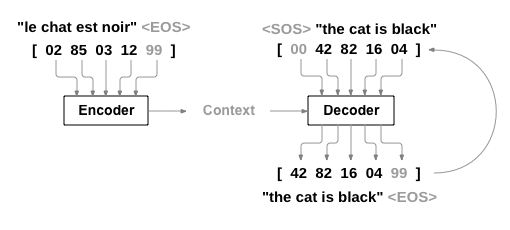

## Define encoder RNN

In [8]:
class EncoderRNN_1(nn.Module):
    def __init__(self, input_size, hidden_size):
        """Initialize encoder network
        Args:
            input_size: size of the input vector (number of unique characters in the input language) <input_lang.n_words>
            hidden_size: size of the hidden state (number of neurons in the hidden layer) <256>
        """
        super(EncoderRNN_1, self).__init__()
        self.hidden_size = hidden_size  # <256> size of the hidden state (number of neurons in the hidden layer)

        # Layer converts the input vector of a symbol to embedding vector of size hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        # GRU (Gated Recurrent Unit) layer is responsible for encoding the input sequence character by character
        # into a hidden state representation. This hidden state contains information about the entire sequence seen so far
        # and will be used by the decoder to generate the output sequence
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(
            1, 1, -1
        )  # input is a character, embedded is a vector of size hidden_size
        output, hidden = self.gru(embedded, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## 4. Attention Decoder RNN (doesn't take into account the encoder hidden state)

Attention позволяет decoder-у смотреть на разные части предложения при генерации своего выхода.
- вычисляем набор attention-весов
- они умножаются на выход encoder-a(``attn_applied``)


In [9]:
# attention декодер
class AttnDecoderRNN_1(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN_1, self).__init__()
        self.hidden_size = hidden_size  # hidden_size is the size of the hidden state
        self.output_size = output_size  # the size of DICT output_lang.n_words
        self.dropout_p = dropout_p  # dropout_p is the probability of dropout
        self.max_length = (
            max_length  # max_length is the maximum length of the input sequence
        )

        self.embedding = nn.Embedding(
            self.output_size, self.hidden_size
        )  # layer to embed the output language
        self.attn = nn.Linear(
            self.hidden_size * 2, self.max_length
        )  # layer to compute attention scores
        self.attn_combine = nn.Linear(
            self.hidden_size * 2, self.hidden_size
        )  # layer to compute the attention-weighted sum of the context vector and the decoder input
        self.dropout = nn.Dropout(self.dropout_p)  # dropout layer
        self.gru = nn.GRU(
            self.hidden_size, self.hidden_size
        )  # GRU layer to compute the decoder hidden states
        self.out = nn.Linear(
            self.hidden_size, self.output_size
        )  # layer to compute the decoder output

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(
            1, 1, -1
        )  # input is a character, embedded is a vector of size hidden_size
        embedded = self.dropout(embedded)

        # attention scores; size == max sequence len
        # this positional approach is called Luong attention. It doesn't take into account the encoder hidden state
        # but only the decoder hidden state
        attn_weights = F.softmax(
            self.attn(
                torch.cat(
                    (embedded[0], hidden[0]), 1
                )  # concatenation of the embedded input and the hidden state of the decoder along the second dimension
            ),
            dim=1,
        )

        # attention-weighted SUM of the context vector and the decoder input
        # bmm - batch matrix multiplication
        attn_applied = torch.bmm(
            attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0)
        )
        # concatenation of the embedded input and the attention-weighted sum of the context vector and the decoder input
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        # linear layer to compute the attention-weighted sum of the context vector and the decoder input
        output = self.attn_combine(output).unsqueeze(
            0
        )  # unsqueeze(0) - add a dimension of size 1 along the first dimension for batch processing (batch size = 1)

        output = F.relu(
            output
        )  # ReLU (Rectified Linear Unit) layer to introduce non-linearity
        output, hidden = self.gru(
            output, hidden
        )  # GRU layer to compute the decoder hidden states
        # softmax layer to compute tthe probabilities of the next character in the output language
        output = F.log_softmax(self.out(output[0]), dim=1)
        return (
            output,
            hidden,
            attn_weights,
        )  # attn_weights - attention scores for visualization purposes

    def initHidden(self):
        """Initialize hidden state with zeros for the first character of the output sequence
        of size 1x1xhidden_size: 1 - batch size, 1 - seq_length, hidden_size - size of the hidden state
        Returns:
            torch.zeros(1, 1, self.hidden_size, device=device)
        """
        return torch.zeros(
            1, 1, self.hidden_size, device=device
        )  # hidden state initialization with zeros for the first character of the output sequence

### 5. Обучение
- создаем input-тензоры (с индексами символов) для каждой пары обучающей выборки
- добавляем EOS-символы и в source, и в target последовательность


In [10]:
# def indexesFromSentence(lang, sentence)->list:
#     '''Obtain the indexes of the characters in the sentence
#     Args:
#         lang: Lang instance for the language of the sentence
#         sentence: sentence to obtain the indexes from
#     Returns:
#         list of indexes of the characters in the sentence
#     '''
#     return [lang.word2index[char] for char in list(sentence)]


def tensorFromSentence(lang: Lang, sentence: str) -> torch.tensor:
    """Obtain the tensor representation of the sentence
    Args:
        lang: Lang instance for the language of the sentence
        sentence: sentence to obtain the tensor representation from
    Returns:
        tensor representation of the sentence
    """
    # indexes = indexesFromSentence(lang, sentence)
    indexes = [lang.word2index[char] for char in list(sentence)]
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair: tuple) -> tuple:
    """Obtain the tensors corresponding to the input and target sentences
    Args:
        pair: tuple of input and target sentences (pair[0] - input sentence, pair[1] - target sentence)
    Returns:
        tuple of tensors corresponding to the input and target sentences
    """
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [11]:
# "Teacher forcing" - conception
# http://minds.jacobs-university.de/sites/default/files/uploads/papers/ESNTutorialRev.pdf
teacher_forcing_ratio = 0.6


def train(
    input_tensor,
    target_tensor,
    encoder,
    decoder,
    encoder_optimizer,
    decoder_optimizer,
    criterion,
    max_length=MAX_LENGTH,
):
    """Train the model for one iteration
    Args:
        input_tensor: tensor representation of the input sentence
        target_tensor: tensor representation of the target sentence
        encoder: encoder model
        decoder: decoder model
        encoder_optimizer: optimizer for the encoder
        decoder_optimizer: optimizer for the decoder
        criterion: loss function
        max_length: maximum length of the input sequence
    Returns:
        loss.item() / target_length: loss value for the current iteration
    """
    encoder_hidden = (
        encoder.initHidden()
    )  # initialize the hidden state of the encoder with zeros
    encoder_optimizer.zero_grad()  # zero the gradients of the encoder optimizer
    decoder_optimizer.zero_grad()  # zero the gradients of the decoder optimizer

    # define the length of the input and target sequences
    input_length = input_tensor.size(0)  # get the length of the input sequence
    target_length = target_tensor.size(0)  # get the length of the target sequence

    # template for the encoder outputs
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ind in range(input_length):  # iterate over the input sequence
        encoder_output, encoder_hidden = encoder(input_tensor[ind], encoder_hidden)
        encoder_outputs[ind] = encoder_output[
            0, 0
        ]  # save the encoder output for the current character of the input sequence

    decoder_input = torch.tensor(
        [[SOS_token]], device=device
    )  # initialize the decoder input with SOS_token

    decoder_hidden = encoder_hidden  # initialize the decoder hidden state with the last hidden state of the encoder

    use_teacher_forcing = (
        True if random.random() < teacher_forcing_ratio else False
    )  # use teacher forcing with probability teacher_forcing_ratio

    if use_teacher_forcing:  # use teacher forcing
        for ind in range(target_length):  # iterate over the target sequence
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )

            # decoder_output - probabilities of the next character in the output language
            loss += criterion(
                decoder_output, target_tensor[ind]
            )  # compute the loss between the decoder output and the ground-truth target

            # teacher forcing: use the ground-truth target as the next input
            decoder_input = target_tensor[
                ind
            ]  # teacher forcing: use the ground-truth target as the next input

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            topv, topi = decoder_output.topk(
                1
            )  # topk - returns the k largest elements of the given input tensor along a given dimension


            # topi - index of the most probable next character in the output language
            # assign topi as the next input to the decoder
            decoder_input = (
                topi.squeeze().detach()
            )  # detach from history as input and squeeze the dimension of size 1

            loss += criterion(decoder_output, target_tensor[di])

            if decoder_input.item() == EOS_token:  # stop if EOS_token is predicted
                break

    loss.backward()
    # encoder update step is called after the decoder has been run for one step
    encoder_optimizer.step()  # update the parameters of the encoder
    decoder_optimizer.step()  # update the parameters of the decoder

    return (
        loss.item() / target_length
    )  # return the loss value for the current iteration (normalized by the target sequence length)

In [42]:
def trainIters(
    encoder,
    decoder,
    n_iters,
    print_every=10000,
    plot_every=100,
    learning_rate=0.01,
    max_iter_without_improvement=5,
):
    plot_losses = [np.inf, np.inf]
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    epochs_without_improvement = 0  # Track consecutive epochs without loss improvement

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    # shuffle the dataset
    training_pairs = [tensorsFromPair(random.choice(pairs)) for i in range(n_iters)]
    criterion = nn.NLLLoss()  # negative log likelihood loss

    for iter in range(1, n_iters + 1):  # iterate over the dataset
        training_pair = training_pairs[iter - 1]  # get the current training pair
        input_tensor = training_pair[0]  # get the input tensor from the training pair
        target_tensor = training_pair[1]  # get the target tensor from the training pair

        loss = train(
            input_tensor,
            target_tensor,
            encoder,
            decoder,
            encoder_optimizer,
            decoder_optimizer,
            criterion,
        )
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print("(%d %d%%) %.4f" % (iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
        # Check for loss improvement
        if iter > 1 and plot_losses[-1] >= plot_losses[-2]:
            epochs_without_improvement += 1
        else:
            epochs_without_improvement = 0

        # Stop training if loss doesn't decrease for max_epochs_without_improvement consecutive epochs
        if epochs_without_improvement >= max_iter_without_improvement:
            print(
                f"Training stopped due to no loss improvement for {max_iter_without_improvement} consecutive epochs."
            )
            break

    showPlot(plot_losses)

### Plotting results

In [13]:
import matplotlib.pyplot as plt

# plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

### 6. Качество

In [14]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    """Evaluate the model on the input sentence
    Args:
        encoder: encoder model
        decoder: decoder model
        sentence: input sentence
        max_length: maximum length of the input sequence
    Returns:
        decoded_words: list of decoded words
        decoder_attentions[:di + 1]: attention scores for the input sequence
    """
    with torch.no_grad():  # disable gradient calculation
        input_tensor = tensorFromSentence(
            input_lang, sentence
        )  # get the tensor representation of the input sentence
        input_length = input_tensor.size()[0]  # get the length of the input sequence
        encoder_hidden = (
            encoder.initHidden()
        )  # initialize the hidden state of the encoder with zeros

        encoder_outputs = torch.zeros(
            max_length, encoder.hidden_size, device=device
        )  # template for the encoder outputs

        for ei in range(input_length):  # iterate over the input sequence
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] += encoder_output[
                0, 0
            ]  # save the encoder output for the current character of the input sequence

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden  # initialize the decoder hidden state with the last hidden state of the encoder

        decoded_words = []  # list of decoded words
        decoder_attentions = torch.zeros(
            max_length, max_length
        )  # template for the attention scores

        for di in range(
            max_length
        ):  # iterate over the maximum length of the input sequence
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )  # compute the decoder output, hidden state and attention scores
            decoder_attentions[
                di
            ] = (
                decoder_attention.data
            )  # save the attention scores for the current character of the input sequence
            topv, topi = decoder_output.data.topk(
                1
            )  # topi - index of the most probable next character in the output language
            if topi.item() == EOS_token:
                decoded_words.append("<EOS>")  # stop if EOS_token is predicted
                break
            else:  # append the decoded word to the list of decoded words
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = (
                topi.squeeze().detach()
            )  # detach from history as input and squeeze the dimension of size 1

        return (
            decoded_words,
            decoder_attentions[: di + 1],
        )  # return the list of decoded words and the attention scores for the input sequence

Можно посмотреть на некоторую пару предложений из обучающей выборки и оценить качество.




In [15]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print(">", pair[0])
        print("=", pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = "".join(output_words)
        print("<", output_sentence)
        print("")

In [16]:
example = "04/21/2020"

### 7. Запускаем обучение

In [17]:
# # http://pytorch.org/
# from os.path import exists
# from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
# platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
# cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
# accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

# !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
# import torch

(500 5%) 1.3839
(1000 10%) 0.7966
(1500 15%) 0.6032
(2000 20%) 0.4585
(2500 25%) 0.4912
(3000 30%) 0.2706
(3500 35%) 0.2734
(4000 40%) 0.1845
(4500 45%) 0.1854
(5000 50%) 0.1420
(5500 55%) 0.1037
(6000 60%) 0.1016
(6500 65%) 0.0782
(7000 70%) 0.0918
(7500 75%) 0.1041
(8000 80%) 0.1032
(8500 85%) 0.1777
(9000 90%) 0.1225
(9500 95%) 0.0867
(10000 100%) 0.0749


<Figure size 640x480 with 0 Axes>

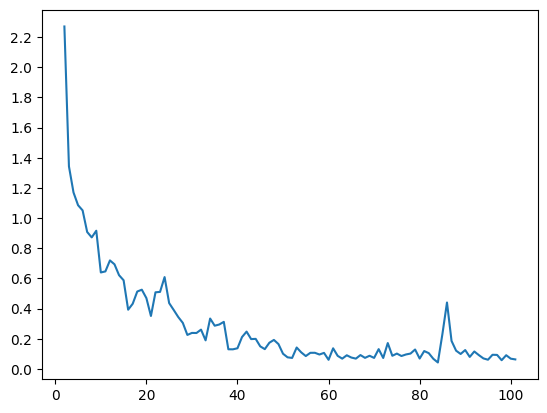

In [43]:
hidden_size = 256
encoder1 = EncoderRNN_1(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN_1(hidden_size, output_lang.n_words, dropout_p=0.2).to(
    device
)

trainIters(
    encoder1, attn_decoder1, 10000, print_every=500, max_iter_without_improvement=500, learning_rate=0.001
)

In [19]:
dataset_test_inside = get_dataset("1/1/1025", "1/1/2024", "%m/%d/%Y", 999)
dataset_test_outside = get_dataset("1/1/2024", "1/1/9999", "%m/%d/%Y", 999)
len(dataset_test_inside), dataset_test_inside[:5]

(999,
 [('29 Nov 1823', '1823, the 29th of November'),
  ('09 January 1224', '1224, the 09th of January'),
  ('07 October 1634', '1634, the 07th of October'),
  ('03 March 1062', '1062, the 03th of March'),
  ('May.14.1434', '1434, the 14th of May')])

In [20]:
def accuracy_on_test(encoder, decoder, dataset_test):

    i = 0
    n = 0
    err_list = []
    for pair in dataset_test:

        # pair[1] - target
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = "".join(output_words)
        # romove <EOS> from output
        output_sentence = output_sentence[:-5]
        n += 1
        if output_sentence == pair[1]:
            i += 1
        else:
            err_list.append((output_sentence, pair[1]))

    return i * 1.0 / n, err_list

In [21]:
res = accuracy_on_test(encoder1, attn_decoder1, dataset_test_inside)
print(f'Accuracy on "inside " dataset: {res[0]:.04f}, number of errors {len(res[1])}')
res[1]


Accuracy on "inside " dataset: 0.7107, number of errors 289


[('1344, the 14th of May', '1434, the 14th of May'),
 ('9963, the 21th of December', '1963, the 21th of December'),
 ('1318, the 05th of May', '1138, the 05th of May'),
 ('3101, the 20th of March', '1301, the 20th of March'),
 ('1294, the 01th of December', '1294, the 10th of December'),
 ('1949, the 17th of April', '1494, the 17th of April'),
 ('2100, the 12th of April', '2020, the 21th of April'),
 ('1256, the 01th of September', '1256, the 10th of September'),
 ('1992, the 13th of December', '1492, the 13th of December'),
 ('2171, the 19th of September', '1271, the 19th of September'),
 ('1992, the 01th of June', '1192, the 06th of January'),
 ('1146, the 22th of April', '1416, the 22th of April'),
 ('157, the 10th of October', '1457, the 10th of October'),
 ('1255, the 13th of May', '1425, the 13th of May'),
 ('8115, the 01th of August', '1815, the 10th of August'),
 ('165, the 09th of August', '1655, the 09th of August'),
 ('1187, the 08th of April', '1817, the 08th of April'),
 (

In [22]:
res = accuracy_on_test(encoder1, attn_decoder1, dataset_test_outside)
print(f'Accuracy on "outside" dataset: {res[0]:.04f}, number of errors {len(res[1])}')

Accuracy on "outside" dataset: 0.7397, number of errors 260


In [23]:
res[1]

[('6566, the 02th of August', '6576, the 20th of August'),
 ('3066, the 10th of January', '3046, the 10th of June'),
 ('8799, the 30th of November', '9879, the 30th of November'),
 ('2880, the 28th of December', '8880, the 22th of December'),
 ('3334, the 01th of March', '3634, the 01th of March'),
 ('9894, the 08th of April', '8994, the 06th of April'),
 ('7869, the 08th of June', '8969, the 07th of January'),
 ('7904, the 30th of September', '9704, the 30th of September'),
 ('7299, the 14th of June', '7929, the 14th of June'),
 ('1215, the 11th of September', '2815, the 11th of September'),
 ('6609, the 14th of April', '4609, the 16th of April'),
 ('6962, the 29th of March', '9162, the 26th of March'),
 ('7949, the 23th of February', '7494, the 23th of February'),
 ('3166, the 18th of October', '8346, the 11th of October'),
 ('8666, the 18th of August', '8466, the 11th of August'),
 ('5236, the 15th of August', '5326, the 15th of August'),
 ('9086, the 08th of March', '8006, the 09th

In [24]:
evaluateRandomly(encoder1, attn_decoder1)

> 15-Nov-2713
= 2713, the 15th of November
< 2713, the 15th of November<EOS>

> 15/08/9944
= 9944, the 15th of August
< 9944, the 15th of August<EOS>

> Jul 09, 909
= 909, the 09th of July
< 909, the 09th of July<EOS>

> 20 January 4510
= 4510, the 20th of January
< 4510, the 20th of January<EOS>

> May 07th, 59
= 59, the 07th of May
< 59, the 07th of May<EOS>

> 19th 05 1075
= 1075, the 19th of May
< 1075, the 19th of May<EOS>

> 16 Sep 7295
= 7295, the 16th of September
< 7295, the 16th of September<EOS>

> 07th 11 3423
= 3423, the 07th of November
< 3423, the 07th of November<EOS>

> 08.06.6024
= 6024, the 08th of June
< 6024, the 08th of June<EOS>

> 27-Feb-744
= 744, the 27th of February
< 744, the 27th of February<EOS>



### 8. Визуализируем Attention

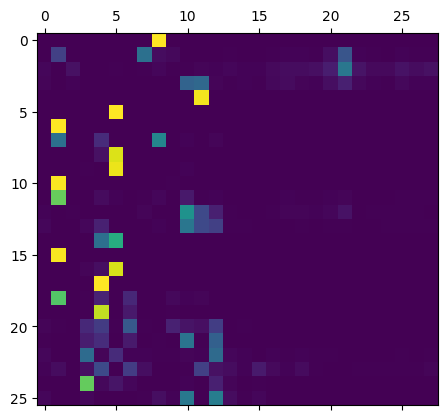

In [25]:
output_words, attentions = evaluate(encoder1, attn_decoder1, "05 October 2017")
plt.matshow(attentions.numpy())

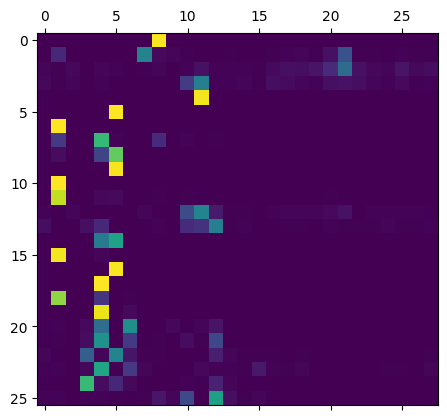

In [26]:
output_words, attentions = evaluate(encoder1, attn_decoder1, "05.10.2017")
plt.matshow(attentions.numpy())

In [27]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar

    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap="bone")
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([""] + list(input_sentence) + ["<EOS>"], rotation=90)
    ax.set_yticklabels([""] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(encoder1, attn_decoder1, input_sentence)
    print("input =", input_sentence)
    print("output =", "".join(list(output_words)))
    showAttention(input_sentence, output_words, attentions)

input = 06 September 1047
output = 1047, the 06th of September<EOS>


<ipython-input-27-645888d7e5f3>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([""] + list(input_sentence) + ["<EOS>"], rotation=90)
<ipython-input-27-645888d7e5f3>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([""] + output_words)


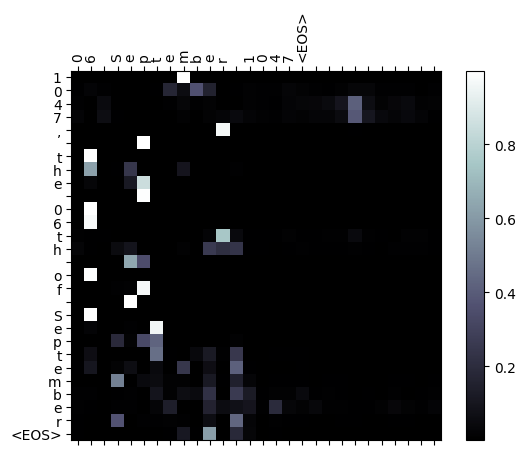

In [28]:
evaluateAndShowAttention("06 September 1047")

input = 04/01/2019
output = 2019, the 04th of January<EOS>


<ipython-input-27-645888d7e5f3>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([""] + list(input_sentence) + ["<EOS>"], rotation=90)
<ipython-input-27-645888d7e5f3>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([""] + output_words)


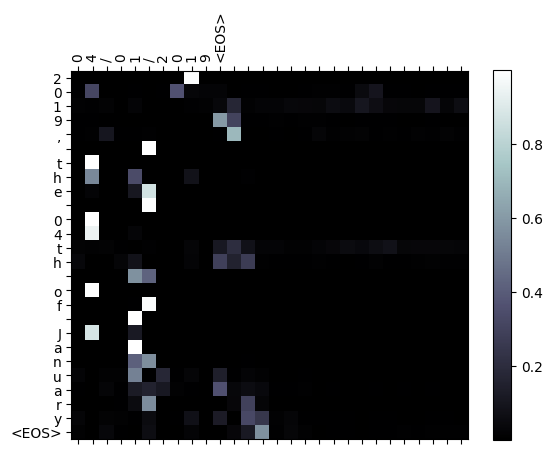

In [29]:
evaluateAndShowAttention("04/01/2019")

input = December 17th, 2019
output = 2019, the 17th of December<EOS>


<ipython-input-27-645888d7e5f3>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([""] + list(input_sentence) + ["<EOS>"], rotation=90)
<ipython-input-27-645888d7e5f3>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([""] + output_words)


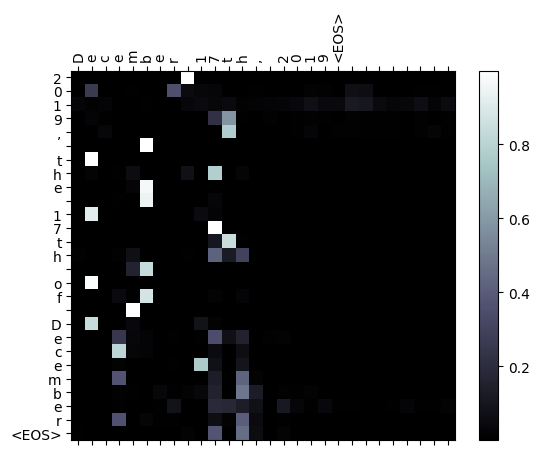

In [30]:
evaluateAndShowAttention("December 17th, 2019")

input = Feb 03, 2018
output = 2018, the 03th of February<EOS>


<ipython-input-27-645888d7e5f3>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([""] + list(input_sentence) + ["<EOS>"], rotation=90)
<ipython-input-27-645888d7e5f3>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([""] + output_words)


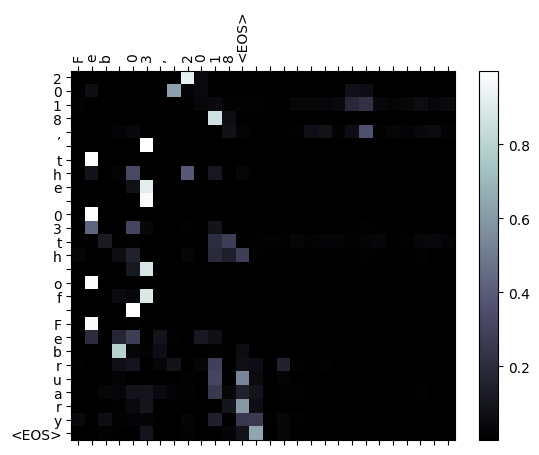

In [31]:
evaluateAndShowAttention("Feb 03, 2018")

### 9. Оценка модели на тесте

Let' select a range of dates beyond the training span of dates.

In [32]:
def accuracy_on_test(encoder, decoder, dataset_test) -> float:
    """Obtain the accuracy of the model on the test dataset
    Args:
        encoder: encoder model
        decoder: decoder model
        dataset_test: test dataset
    Returns:
        accuracy: accuracy of the model on the test dataset"""
    i = 0
    error_list = []
    for pair in dataset_test:  # iterate over the test dataset
        pred = []
        # pair[1] - target
        output_words, attentions = evaluate(
            encoder, decoder, pair[0]
        )  # evaluate the model on the input sentence
        output_sentence = "".join(
            output_words
        )  # convert the list of decoded words to a string
        target_length = len(pair[1])
        # output_sentence - pred
        is_equal = int(output_sentence[:target_length] == pair[1])
        if is_equal:
            i += 1  # update the number of correct predictions
        else:
            error_list.append((pair[1], output_sentence))
    return (
        i * 1.0 / len(dataset_test),
        error_list,
    )  # return the accuracy of the model on the test dataset

In [33]:
res = accuracy_on_test(encoder1, attn_decoder1, dataset_test_inside)
print(f'Accuracy on "inside " dataset: {res[0]:.04f}, number of errors {len(res[1])}')
res = accuracy_on_test(encoder1, attn_decoder1, dataset_test_outside)
print(f'Accuracy on "outside" dataset: {res[0]:.04f}, number of errors {len(res[1])}')

Accuracy on "inside " dataset: 0.7227, number of errors 277
Accuracy on "outside" dataset: 0.7337, number of errors 266


### Исправление функции внимания и улучшение качества

Заменим в слое Attention score функции по примерам https://pytorch.org/tutorials/beginner/deploy_seq2seq_hybrid_frontend_tutorial.html#define-decoders-attention-module

Рассмотрим функцию 'general' из примера.

In [34]:
# attention декодер
class AttnDecoderRNN_2(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        """Decoder with attention mechanism
        Args:
            hidden_size: size of the hidden state (number of neurons in the hidden layer) <256>
            output_size: size of the output vector (number of unique characters in the output language) <output_lang.n_words>
            dropout_p: dropout probability <0.1>
            max_length: maximum length of the input sequence <MAX_LENGTH>
        """

        super(AttnDecoderRNN_2, self).__init__()
        self.hidden_size = hidden_size  # Size of the hidden state in the decoder <256>
        self.output_size = output_size  # Number of characters in the output language <output_lang.n_words>
        self.dropout_p = dropout_p  # Dropout probability <0.1>
        self.max_length = max_length  # Maximum length of the input sequence <MAX_LENGTH>. It used to initialize the attention layer

        # Layer to convert the last hidden state of the encoder to a vector of size hidden_size
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        # Layer to compute attention scores
        self.attn = nn.Linear(self.hidden_size, self.hidden_size)
        # Layer to compute the attention-weighted sum of the context vector and the decoder input
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        # Dropout layer to prevent overfitting
        self.dropout = nn.Dropout(self.dropout_p)
        # GRU (Gated Recurrent Unit) layer to compute the decoder hidden states
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        # Linear layer to compute the decoder output probabilities (log softmax is applied later)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    # Добавили функцию для подсчета score
    def general_score(self, hidden, encoder_output):
        """Compute attention scores for every encoder vector using a linear layer (size of max_length)
        Each element defines the importance of the corresponding encoder output
        It obtains the attention weights by multiplying the encoder output by a trainable weight matrix
        Args:
            hidden: previous decoder hidden state
            encoder_output: encoder outputs
        Returns:
            energy: attention scores"""
        energy = self.attn(
            encoder_output
        )  # compute attention scores using a linear layer

        # scalar product of the previous decoder hidden state and the attention scores and
        # sum over the hidden size to get a scalar value
        # sum of element-wise multiplication of the previous decoder hidden state and the attention scores
        return torch.sum(hidden * energy, dim=2)  # 2 is the dimension to sum over

    def forward(self, input, hidden, encoder_outputs):
        """Args:
        input: input character index
        hidden: previous decoder hidden state
        encoder_outputs: encoder outputs
        """
        embedded = self.embedding(input).view(
            1, 1, -1
        )  # reshape input to (batch_size=1, seq_length=1, -1) -1: to infer the size of the third dimension. In this context, it ensures that the reshaped tensor has the appropriate shape to be passed into the GRU layer
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.general_score(hidden, encoder_outputs), dim=1
        )  # compute attention scores using a linear layer and apply softmax to get attention weights
        attn_applied = torch.bmm(
            attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0)
        )

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

Обучим модель с новым Декодером.

(500 0%) 2.2315
(1000 0%) 1.3053
(1500 0%) 1.0750
(2000 0%) 0.9752
(2500 0%) 0.9705
(3000 0%) 0.8505
(3500 0%) 0.7444
(4000 0%) 0.7203
(4500 0%) 0.6585
(5000 1%) 0.5941
(5500 1%) 0.6024
(6000 1%) 0.5751
(6500 1%) 0.5882
(7000 1%) 0.6861
(7500 1%) 0.5104
(8000 1%) 0.4863
(8500 1%) 0.5226
(9000 1%) 0.5197
(9500 1%) 0.4584
(10000 2%) 0.4643
(10500 2%) 0.4516
(11000 2%) 0.4330
(11500 2%) 0.4750
(12000 2%) 0.3530
(12500 2%) 0.2975
(13000 2%) 0.3191
(13500 2%) 0.2630
(14000 2%) 0.2628
(14500 2%) 0.2443
(15000 3%) 0.1984
(15500 3%) 0.2332
(16000 3%) 0.2265
(16500 3%) 0.2378
(17000 3%) 0.1666
(17500 3%) 0.1915
(18000 3%) 0.1948
(18500 3%) 0.1366
(19000 3%) 0.1273
(19500 3%) 0.1196
(20000 4%) 0.1068
(20500 4%) 0.1037
(21000 4%) 0.0963
(21500 4%) 0.0911
(22000 4%) 0.0837
(22500 4%) 0.0733
(23000 4%) 0.0638
(23500 4%) 0.0793
(24000 4%) 0.0552
(24500 4%) 0.0466
(25000 5%) 0.0425
(25500 5%) 0.0367
(26000 5%) 0.0291
(26500 5%) 0.0235
(27000 5%) 0.0261
(27500 5%) 0.0151
(28000 5%) 0.0130
(28500 5%) 0

<Figure size 640x480 with 0 Axes>

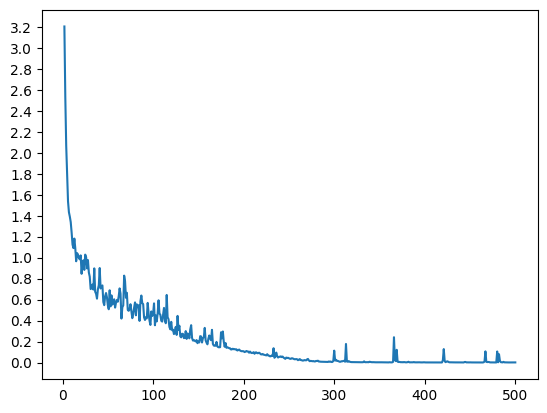

In [52]:
hidden_size = 256
encoder2 = EncoderRNN_1(input_lang.n_words, hidden_size).to(device)
attn_decoder2 = AttnDecoderRNN_2(hidden_size, output_lang.n_words, dropout_p=0.1).to(
    device
)

trainIters(
    encoder2, attn_decoder2, 500000, print_every=500, max_iter_without_improvement=500, learning_rate=1e-4
)

In [53]:
res = accuracy_on_test(encoder2, attn_decoder2, dataset_test_inside)
print(f'Accuracy on "inside " dataset: {res[0]:.04f}, number of errors {len(res[1])}')
res = accuracy_on_test(encoder2, attn_decoder2, dataset_test_outside)
print(f'Accuracy on "outside" dataset: {res[0]:.04f}, number of errors {len(res[1])}')

Accuracy on "inside " dataset: 1.0000, number of errors 0
Accuracy on "outside" dataset: 0.9980, number of errors 2


In [54]:
res[1]

[('3747, the 24th of November', '3477, the 24th of November<EOS>'),
 ('9221, the 29th of December', '9212, the 29th of December<EOS>')]

Посмотрим, как изменились коэффициенты внимания.

input = December 17th, 2021
output = 2021, the 18th of December<EOS>


<ipython-input-27-645888d7e5f3>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([""] + list(input_sentence) + ["<EOS>"], rotation=90)
<ipython-input-27-645888d7e5f3>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([""] + output_words)


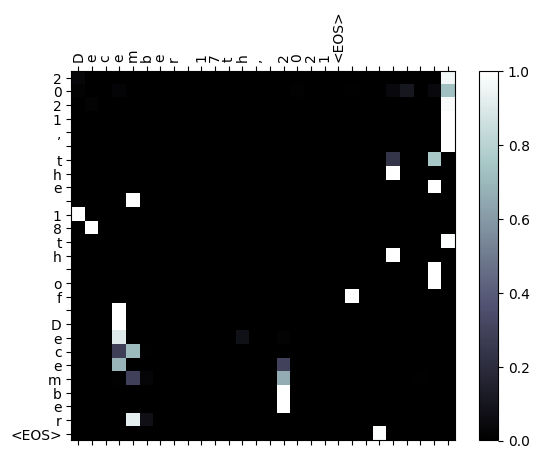

In [55]:
evaluateAndShowAttention("December 17th, 2021")

input = 17th Dec 2021
output = 2021, the 17th of Jane<EOS>


<ipython-input-27-645888d7e5f3>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([""] + list(input_sentence) + ["<EOS>"], rotation=90)
<ipython-input-27-645888d7e5f3>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([""] + output_words)


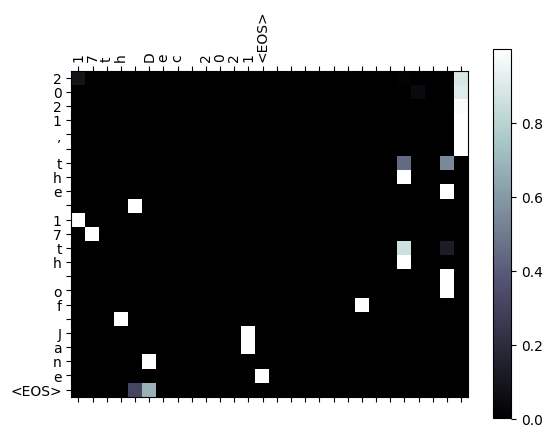

In [56]:
evaluateAndShowAttention("17th Dec 2021")

Теперь последовательность декодируется верно.

In [57]:
evaluateRandomly(encoder2, attn_decoder2)

> Nov.23.8803
= 8803, the 23th of November
< 8803, the 23th of November<EOS>

> 30th of March, 1652
= 1652, the 30th of March
< 1652, the 30th of March<EOS>

> Jul27281
= 281, the 27th of July
< 281, the 27th of July<EOS>

> Jan288038
= 8038, the 28th of January
< 8038, the 28th of January<EOS>

> August 29th, 8612
= 8612, the 29th of August
< 8612, the 29th of August<EOS>

> May 27, 7128
= 7128, the 27th of May
< 7128, the 27th of May<EOS>

> 27.10.9351
= 9351, the 27th of October
< 9351, the 27th of October<EOS>

> 05th of June, 1511
= 1511, the 05th of June
< 1511, the 05th of June<EOS>

> 18 Oct 940
= 940, the 18th of October
< 940, the 18th of October<EOS>

> Sep.09.4250
= 4250, the 09th of September
< 4250, the 09th of September<EOS>



In [62]:
input_sentence = "07 05//////1967"
output_words, attentions = evaluate(encoder1, attn_decoder1, input_sentence)
print("input =", input_sentence)
print("output =", "".join(list(output_words)))
output_words, attentions = evaluate(encoder2, attn_decoder2, input_sentence)
print("input =", input_sentence)
print("output =", "".join(list(output_words)))

input = 07 05//////1967
output = 1967, the 07th of May<EOS>
input = 07 05//////1967
output = 1967, the 07th of May<EOS>


Попробуйте самостоятельно поменять функции score на 'dot' и 'concat' из примера.

1. If train dataset include test dataset range then metrics are quite good.
1. Increasing drop_out value to 0.2 led to unstable learning and worse metrics.
1. Increasing `teacher_forcing_ratio` lead to force teacher learnig


ToDo:
1. save encoders and decoders as pickle


In [66]:
# save encoders and decoders to pickle files
import pickle

with open("encoder1.pickle", "wb") as f:
    pickle.dump(encoder1, f)
with open("attn_decoder1.pickle", "wb") as f:
    pickle.dump(attn_decoder1, f)
with open("encoder2.pickle", "wb") as f:
    pickle.dump(encoder2, f)
with open("attn_decoder2.pickle", "wb") as f:
    pickle.dump(attn_decoder2, f)